# Installing Libraries, Loading Models and Dataset

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=33ce63c72faf469dfdf00a5482dea9d7e8f3f17bd3402837548a1c5b56273e49
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import os
import math
import torch
import random
import shutil
import zipfile
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
from google.colab import drive,files
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

In [ ]:
# Define the data transformations
mean, std = (0.5071, 0.4865, 0.4409),  (0.2673, 0.2564, 0.2762)   #for CIFAR 100
transform = transforms.Compose([
    # transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_feature_model(model):        # Remove the classifiers to get features from the final conv layer
  features_model = nn.Sequential(*list(model.features.children()))
  return features_model


def get_model(model_name):    #generic function to get classifier model and features model
  if model_name == "student":
    model = models.vgg11(pretrained=True)
  elif model_name == "teacher":
    model = models.vgg16(pretrained=True)
  elif model_name == "principal":
    model = models.vgg19(pretrained=True)
  else:
    print("Invalid model name")
    return None

  model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=100)  # Adjust for CIFAR-100 output classes
  model = model.to(device)
  features_model = get_feature_model(model)
  features_model = features_model.to(device)
  return model, features_model

100%|██████████| 169M/169M [00:25<00:00, 6.55MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(len(train_loader)*64,len(test_loader)*64)

50048 10048


# Saving, Restoring Model Utils

**Saving model weights**

In [ ]:
# Define file paths for each model
model_paths = {
    'teacher_model': '/content/teacher_model.pth',
    'student_fm': '/content/student_fm.pth',
    'student_crd': '/content/student_crd.pth',
    'student_lm': '/content/student_lm.pth',
    'student_indep': '/content/student_indep.pth'
}

# Save each model's state dictionary
torch.save(teacher_model.state_dict(), model_paths['teacher_model'])
torch.save(student_fm.state_dict(), model_paths['student_fm'])
torch.save(student_crd.state_dict(), model_paths['student_crd'])
torch.save(student_lm.state_dict(), model_paths['student_lm'])
torch.save(student_indep.state_dict(), model_paths['student_indep'])

paths = [
    '/content/teacher_model.pth',
    '/content/student_fm.pth',
    '/content/student_crd.pth',
    '/content/student_lm.pth',
    '/content/student_indep.pth'
]

# # Zip file path
zip_path = '/content/models.zip'

# Create a zip file containing all model files
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for model_path in paths:
        if os.path.exists(model_path):
            zipf.write(model_path, os.path.basename(model_path))
        else:
            print(f"File not found: {model_path}")

# Check and print the size of the zip file
zip_size = os.path.getsize(zip_path) / (1024 * 1024)  # Convert to MB
print(f"Zip file size: {zip_size:.2f} MB")


# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path in Google Drive where you want to save the zip file
drive_path = '/content/drive/MyDrive/atml_pa3_models.zip'

# Step 3: Move the zip file to Google Drive
shutil.move('/content/models.zip', drive_path)

print(f"Zip file moved to Google Drive at: {drive_path}")

teacher_model.pth: 513.74 MB
student_fm.pth: 492.78 MB
student_crd.pth: 492.78 MB
student_lm.pth: 492.78 MB
student_indep.pth: 492.78 MB


**Getting model weights**

In [ ]:
# Define file paths for each model
model_paths = {
    'teacher_model': '/content/teacher_model.pth',
    'student_fm': '/content/student_fm.pth',
    'student_crd': '/content/student_crd.pth',
    'student_lm': '/content/student_lm.pth',
    'student_indep': '/content/student_indep.pth'
}

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define paths
drive_path = '/content/drive/MyDrive/atml_pa3_models.zip'  # Path to the zip file in Google Drive
destination_path = '/content/models.zip'  # Destination in Colab's content directory

# Step 3: Copy the zip file from Google Drive to /content
shutil.copy(drive_path, destination_path)

# Step 4: Unzip the file in /content
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("Files extracted to /content/")


#Init the models
teacher_model, _ = get_model('teacher')
student_fm,    _ = get_model('student')
student_crd,   _ = get_model('student')
student_lm,    _ = get_model('student')
student_indep, _ = get_model('student')

# Load each model's state dictionary
teacher_model.load_state_dict(torch.load(model_paths['teacher_model']))
student_fm.load_state_dict(torch.load(model_paths['student_fm']))
student_crd.load_state_dict(torch.load(model_paths['student_crd']))
student_lm.load_state_dict(torch.load(model_paths['student_lm']))
student_indep.load_state_dict(torch.load(model_paths['student_indep']))

Mounted at /content/drive
Files extracted to /content/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 209MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

<All keys matched successfully>

# Knowledge Distillation Utils

In [ ]:
def get_features_and_logits(model,feature_model,inputs,student=True, crd=False):
    #will return the same logits as long as model.eval()  is set (i.e. no learning is happening hence same LOGITs)
    if not student:
      model.eval()
      feature_model.eval()
      features = feature_model(inputs)
      # if crd:
      return features,None    #teacher logits NOT required in CRD / Hint
      # logits = model.classifier(features.view(features.size(0), -1))  #to save on time (as teacher doesnt need to LEARN)
    else:
      model.train()
      features = feature_model(inputs)
      logits = model(inputs) #actual student model does need to LEARN hence repeating it twice

    # print("feature shape",features.shape,"logits shape",logits.shape)
    return features, logits

In [ ]:
def finetune_teacher(model, train_loader, num_epochs=3, alpha=1e-3):
    """Fine-tune the model on the training data."""
    print("Finetuning the model on this data")
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)
    num_batches = len(train_loader)

    for epoch in range(num_epochs):
        running_loss = 0.0
        # running_accuracy = 0.0
        correct = 0
        total = 0
        for batch_index, (inputs, labels) in enumerate(train_loader):

            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_index % 300 == 0 or batch_index == 750:
                print(f'Batch {batch_index + 1}/{num_batches} - Loss: {loss.item():.4f} Accuracy: {(correct/total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy =  correct / total
        print(f'------------------------->Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f} Accuracy : {epoch_accuracy * 100:.2f}%')

    return epoch_loss, epoch_accuracy

In [ ]:
def train_student(student, teacher, train_loader, kd, num_epochs=10, alpha=1e-3,  features_student=None, features_teacher=None):
    """Train the model on the training data."""
    student.train()
    teacher.eval()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=alpha)
    num_batches = len(train_loader)

    if kd is None:
      print("Training the student on this data independently")
    else:
      print("Distilling the knowledge and training the student on this data",kd.__class__.__name__)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        correct = 0
        total = 0
        for batch_index, (inputs, labels) in enumerate(train_loader):

            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if kd is None:      #independent student
              outputs = student(inputs)
              distillation_loss = 0.0
            else:
              if kd.__class__.__name__ in [ 'LogitMatching' , 'LabelSmoothingRegularization', 'DecoupledLogitMatching'] :

                  #get teacher's logits and student's logits
                  with torch.no_grad():
                    teacher_outputs = teacher(inputs)
                  outputs = student(inputs)

                  if kd.__class__.__name__ == 'LogitMatching':
                    distillation_loss = kd(outputs, teacher_outputs)
                  elif kd.__class__.__name__ == 'LabelSmoothingRegularization':
                   distillation_loss = kd(outputs,labels)
                  else:     #DecoupledLogitMatching
                    distillation_loss = kd(outputs, teacher_outputs, labels)

              elif kd.__class__.__name__ == 'FeatureMatching':
                  #get features of student , teacher and logits of student
                  feat_s, outputs = get_features_and_logits(student,features_student,inputs)
                  feat_t, _ = get_features_and_logits(teacher,features_teacher,inputs,student=False)
                  distillation_loss = kd(feat_s, feat_t)

            classification_loss = criterion(outputs, labels)
            total_loss = classification_loss + distillation_loss
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_index % 200 == 0 or batch_index == 750:
                print(f'Batch {batch_index + 1}/{num_batches} - Loss: {total_loss.item():.4f} Accuracy: {(correct/total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct/total
        print(f'------------------------->Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f} Accuracy : {epoch_accuracy * 100:.2f}%')

    return epoch_loss, epoch_accuracy

In [ ]:
def evaluate(model, dataloader, device):
    print("---------------------------EVALUATING THE MODEL------------------------")
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    num_batches = len(dataloader)  # Get total number of batches
    probs = []

    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(dataloader):

            batch_size = images.size(0)
            if batch_size < 64:
              print(f"skipping last batch of size {batch_size} --- gives shape error")
              break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            prob = F.softmax(outputs, dim=1)
            probs.append(prob.cpu().numpy())
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Print progress every 10 batches (you can adjust this as needed)
            if batch_index % 20 == 0:
                print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    print(f'Final Accuracy: {accuracy * 100:.2f}%')
    probs_array = np.concatenate(probs)
    return accuracy, probs

In [ ]:
def plot_accuracies(accuracies, model_labels, title='Model Accuracies'):
    """
    Plots the accuracies of different models.

    Parameters:
    accuracies (list of float): A list of accuracy values for each model.
    model_labels (list of str): A list of labels corresponding to each model.

    """
    # Ensure the inputs are valid
    if len(accuracies) != len(model_labels):
        raise ValueError("The number of accuracies must match the number of model labels.")

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.bar(model_labels, accuracies)

    # Adding title and labels
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')

    # Optionally, add accuracy values on top of the bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x labels for better visibility
    plt.tight_layout()
    plt.show()


In [ ]:
class CIFAR100IdxSample(torchvision.datasets.CIFAR100):          #loaded for Knowledge Distillation with CRD
	def __init__(self, root, train=True,transform=None, target_transform=None,download=False, n=4096, mode='exact', percent=1.0):
		super().__init__(root=root, train=train, download=download,transform=transform, target_transform=target_transform)
		self.n = n
		self.mode = mode

		num_classes = 100
		num_samples = len(self.data)
		labels = self.targets

		self.cls_positive = [[] for _ in range(num_classes)]
		for i in range(num_samples):
			self.cls_positive[labels[i]].append(i)

		self.cls_negative = [[] for _ in range(num_classes)]
		for i in range(num_classes):
			for j in range(num_classes):
				if j == i:
					continue
				self.cls_negative[i].extend(self.cls_positive[j])

		self.cls_positive = [np.asarray(self.cls_positive[i]) for i in range(num_classes)]
		self.cls_negative = [np.asarray(self.cls_negative[i]) for i in range(num_classes)]

		if 0 < percent < 1:
			num = int(len(self.cls_negative[0]) * percent)
			self.cls_negative = [np.random.permutation(self.cls_negative[i])[0:num]
								 for i in range(num_classes)]

		self.cls_positive = np.asarray(self.cls_positive)
		self.cls_negative = np.asarray(self.cls_negative)

	def __getitem__(self, index):
		img, target = self.data[index], self.targets[index]

		img = Image.fromarray(img)
		if self.transform is not None:
			img = self.transform(img)

		if self.target_transform is not None:
			target = self.target_transform(target)

		if self.mode == 'exact':
			pos_idx = index
		elif self.mode == 'relax':
			pos_idx = np.random.choice(self.cls_positive[target], 1)[0]
		else:
			raise NotImplementedError(self.mode)
		replace = True if self.n > len(self.cls_negative[target]) else False
		neg_idx = np.random.choice(self.cls_negative[target], self.n, replace=replace)
		sample_idx = np.hstack((np.asarray([pos_idx]), neg_idx))

		return img, target, index, sample_idx

# Task 3.1 (Logit Matching vs Label Smoothing vs Decoupling)

In [ ]:
class LogitMatching(nn.Module):  #smoothes teacher logits as well (going from Peaky dist to Uniform dist by increasing Temperature T)
	def __init__(self, T=3.0):
		super(LogitMatching, self).__init__()
		self.T = T      #Temperature for Soft Targets ... lower the T, less the smoothing, less the error

	def forward(self, out_s, out_t):
    # loss = F.mse_loss(out_s, out_t)
		loss = self.T * self.T * F.kl_div(
                                        F.log_softmax(out_s/self.T, dim=1),
                                        F.softmax(out_t/self.T, dim=1),
                                        reduction='batchmean'
          )  #cross entropy loss of softened probabilities

		return loss

class LabelSmoothingRegularization(nn.Module):
    def __init__(self, num_classes, smoothing=0.35):
        super(LabelSmoothingRegularization, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing

    def forward(self, logits, labels):
        # Convert logits to smoothed probability distribution using true labels
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, labels.unsqueeze(1), 1 - self.smoothing)

        # Calculate smoothed cross-entropy loss
        loss = -torch.sum(true_dist * F.log_softmax(logits, dim=1) , dim=1).mean()
        return loss




class DecoupledLogitMatching(nn.Module):   # KL Divergence of target probs + KL Divergence of non target probs
    def __init__(self, T=3.0):
        super(DecoupledLogitMatching, self).__init__()
        self.T = T

    def forward(self, student_logits, teacher_logits, target_class):

        # print(student_logits.shape, teacher_logits.shape, target_class.shape)

        # Softmax smoothened probabilities for the teacher and student
        student_probs = F.softmax(student_logits / self.T, dim=1)
        teacher_probs = F.softmax(teacher_logits / self.T , dim=1)

        # Calculate target class probabilities pt^T and pt^S
        pt_T = teacher_probs[:, target_class]  # Target class prob ... teacher
        pt_S = student_probs[:, target_class]  # Target class prob ... student

        # Calculate non-target probability sum p\t for Teacher, Student
        p_not_t_T = 1 - pt_T
        p_not_t_S = 1 - pt_S

        # Non-target mask
        non_target_mask = torch.ones_like(teacher_probs, dtype=torch.bool)
        non_target_mask[:, target_class] = 0

        # Calculate non-target probabilities pˆt^T and pˆt^S
        p_hat_T = teacher_probs[non_target_mask].view(teacher_probs.size(0), -1)
        p_hat_S = student_probs[non_target_mask].view(student_probs.size(0), -1)

        # print("tgtclass",target_class.shape)
        # print("proba",teacher_probs.shape)
        # print("tgt",pt_T.shape)
        # print("nontgt",p_hat_T.shape)

        # print("pt_S,pt_T",pt_S,pt_T)
        # print("p_hat_S,p_hat_T",p_hat_S,p_hat_T)

        # Target class KD term: KL(b^T || b^S)
        target_class_kd_loss = F.kl_div(pt_S.log(), pt_T, reduction="batchmean")

        # Non-target class KD term: (1 - pt^T) * KL(pˆt^T || pˆt^S)
        non_target_kd_loss = (p_not_t_T * F.kl_div(p_hat_S.log(), p_hat_T, reduction="batchmean")).mean()

        total_loss = target_class_kd_loss + non_target_kd_loss
        return total_loss * (self.T ** 2)

In [ ]:
#finetune teacher
teacher_model, features_teacher = get_model('teacher')
finetune_teacher(teacher_model, train_loader, num_epochs=8, alpha=1e-4)
teacher_acc, teacher_probs = evaluate(teacher_model, test_loader, device)
#63.36% after 11 epochs .....

Finetuning the model on this data
Batch 1/782 - Loss: 5.0626 Accuracy: 0.00%
Batch 301/782 - Loss: 2.4861 Accuracy: 24.97%
Batch 601/782 - Loss: 1.9478 Accuracy: 33.80%
Batch 751/782 - Loss: 1.6919 Accuracy: 36.50%
------------------------->Epoch [1/8], Loss: 2.4160 Accuracy : 36.97%
Batch 1/782 - Loss: 1.5680 Accuracy: 56.25%
Batch 301/782 - Loss: 1.5967 Accuracy: 56.31%
Batch 601/782 - Loss: 1.1666 Accuracy: 57.11%
Batch 751/782 - Loss: 1.3940 Accuracy: 57.60%
------------------------->Epoch [2/8], Loss: 1.4869 Accuracy : 57.76%
Batch 1/782 - Loss: 1.3857 Accuracy: 56.25%
Batch 301/782 - Loss: 0.6147 Accuracy: 68.74%
Batch 601/782 - Loss: 1.2348 Accuracy: 68.69%
Batch 751/782 - Loss: 1.2937 Accuracy: 68.48%
------------------------->Epoch [3/8], Loss: 1.0788 Accuracy : 68.46%
Batch 1/782 - Loss: 0.7338 Accuracy: 82.81%
Batch 301/782 - Loss: 0.9049 Accuracy: 77.11%
Batch 601/782 - Loss: 0.7001 Accuracy: 76.64%
Batch 751/782 - Loss: 0.7155 Accuracy: 76.35%
------------------------->Epo

In [ ]:
#get a new student each time and train independently
student_model, features_student = get_model('student')
train_student(student_model, teacher_model, train_loader, None, num_epochs=5, alpha=1e-4)
indep_acc, indep_probs = evaluate(student_model, test_loader, device)
student_indep = student_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 92.0MB/s]


Training the student on this data independently
Batch 1/782 - Loss: 5.2888 Accuracy: 0.00%
Batch 201/782 - Loss: 2.5875 Accuracy: 19.94%
Batch 401/782 - Loss: 2.1388 Accuracy: 28.07%
Batch 601/782 - Loss: 2.1135 Accuracy: 32.75%
Batch 751/782 - Loss: 1.7687 Accuracy: 35.29%
------------------------->Epoch [1/5], Loss: 2.4845 Accuracy : 35.77%
Batch 1/782 - Loss: 1.8981 Accuracy: 45.31%
Batch 201/782 - Loss: 1.4611 Accuracy: 54.23%
Batch 401/782 - Loss: 1.5911 Accuracy: 55.31%
Batch 601/782 - Loss: 1.2392 Accuracy: 55.78%
Batch 751/782 - Loss: 1.5136 Accuracy: 56.21%
------------------------->Epoch [2/5], Loss: 1.5503 Accuracy : 56.25%
Batch 1/782 - Loss: 0.8865 Accuracy: 78.12%
Batch 201/782 - Loss: 1.2526 Accuracy: 68.22%
Batch 401/782 - Loss: 1.1845 Accuracy: 67.99%
Batch 601/782 - Loss: 0.8665 Accuracy: 68.07%
Batch 751/782 - Loss: 1.1623 Accuracy: 68.12%
------------------------->Epoch [3/5], Loss: 1.0826 Accuracy : 68.11%
Batch 1/782 - Loss: 0.9258 Accuracy: 68.75%
Batch 201/782 -

In [ ]:
#get a new student each time and train on logit matching
criterion_logitmatching = LogitMatching()
student_model, features_student = get_model('student')
train_student(student_model, teacher_model, train_loader, criterion_logitmatching, num_epochs=5, alpha=1e-4)
lm_acc, lm_probs = evaluate(student_model, test_loader, device)
student_lm = student_model

Distilling the knowledge and training the student on this data LogitMatching
Batch 1/782 - Loss: 33.0214 Accuracy: 1.56%
Batch 201/782 - Loss: 16.4528 Accuracy: 23.87%
Batch 401/782 - Loss: 13.8393 Accuracy: 32.13%
Batch 601/782 - Loss: 14.2857 Accuracy: 36.44%
Batch 751/782 - Loss: 9.1629 Accuracy: 38.65%
------------------------->Epoch [1/5], Loss: 14.9835 Accuracy : 39.13%
Batch 1/782 - Loss: 8.9050 Accuracy: 57.81%
Batch 201/782 - Loss: 9.6456 Accuracy: 56.88%
Batch 401/782 - Loss: 7.2025 Accuracy: 57.82%
Batch 601/782 - Loss: 10.0717 Accuracy: 58.60%
Batch 751/782 - Loss: 10.6740 Accuracy: 58.79%
------------------------->Epoch [2/5], Loss: 8.9748 Accuracy : 58.92%
Batch 1/782 - Loss: 5.6703 Accuracy: 68.75%
Batch 201/782 - Loss: 4.9572 Accuracy: 69.26%
Batch 401/782 - Loss: 6.9176 Accuracy: 69.78%
Batch 601/782 - Loss: 6.1523 Accuracy: 69.57%
Batch 751/782 - Loss: 5.6271 Accuracy: 69.44%
------------------------->Epoch [3/5], Loss: 6.2332 Accuracy : 69.45%
Batch 1/782 - Loss: 5.1

In [ ]:
#get a new student each time and train on label smoothing regularization
criterion_labelsmoothing = LabelSmoothingRegularization(num_classes=100) # Define the number of classes in CIFAR-100
student_model, features_student = get_model('student')
train_student(student_model, teacher_model, train_loader, criterion_labelsmoothing, num_epochs=5, alpha=1e-4)
lsr_acc, _ = evaluate(student_model, test_loader, device)

Distilling the knowledge and training the student on this data LabelSmoothingRegularization
Batch 1/782 - Loss: 10.8739 Accuracy: 0.00%
Batch 201/782 - Loss: 6.4905 Accuracy: 19.72%
Batch 401/782 - Loss: 5.5616 Accuracy: 28.20%
Batch 601/782 - Loss: 5.9641 Accuracy: 33.47%
Batch 751/782 - Loss: 6.0983 Accuracy: 35.95%
------------------------->Epoch [1/5], Loss: 6.3184 Accuracy : 36.45%
Batch 1/782 - Loss: 5.1626 Accuracy: 56.25%
Batch 201/782 - Loss: 5.0121 Accuracy: 57.03%
Batch 401/782 - Loss: 4.6515 Accuracy: 57.43%
Batch 601/782 - Loss: 5.1734 Accuracy: 57.63%
Batch 751/782 - Loss: 4.5890 Accuracy: 57.87%
------------------------->Epoch [2/5], Loss: 4.9811 Accuracy : 57.98%
Batch 1/782 - Loss: 4.7482 Accuracy: 60.94%
Batch 201/782 - Loss: 4.1601 Accuracy: 70.53%
Batch 401/782 - Loss: 4.1781 Accuracy: 71.14%
Batch 601/782 - Loss: 4.1265 Accuracy: 70.98%
Batch 751/782 - Loss: 3.9449 Accuracy: 70.73%
------------------------->Epoch [3/5], Loss: 4.2834 Accuracy : 70.65%
Batch 1/782 - 

In [ ]:
# get a new student each time and train on decoupled logit matching
criterion_decoupled_logitmatching = DecoupledLogitMatching()
student_model, features_student = get_model('student')
train_student(student_model, teacher_model, train_loader, criterion_decoupled_logitmatching, num_epochs=5, alpha=1e-4)
dlm_acc, _ = evaluate(student_model, test_loader, device)

Distilling the knowledge and training the student on this data DecoupledLogitMatching
Batch 1/782 - Loss: 50.8091 Accuracy: 0.00%
Batch 201/782 - Loss: 25.6936 Accuracy: 21.70%
Batch 401/782 - Loss: 21.7492 Accuracy: 29.99%
Batch 601/782 - Loss: 18.4823 Accuracy: 34.52%
Batch 751/782 - Loss: 24.2571 Accuracy: 36.93%
------------------------->Epoch [1/5], Loss: 23.4403 Accuracy : 37.33%
Batch 1/782 - Loss: 14.0452 Accuracy: 56.25%
Batch 201/782 - Loss: 17.8219 Accuracy: 55.57%
Batch 401/782 - Loss: 13.8154 Accuracy: 55.74%
Batch 601/782 - Loss: 10.4817 Accuracy: 56.03%
Batch 751/782 - Loss: 15.5365 Accuracy: 56.46%
------------------------->Epoch [2/5], Loss: 14.1637 Accuracy : 56.53%
Batch 1/782 - Loss: 8.9900 Accuracy: 68.75%
Batch 201/782 - Loss: 12.3791 Accuracy: 66.43%
Batch 401/782 - Loss: 6.1602 Accuracy: 66.65%
Batch 601/782 - Loss: 13.3202 Accuracy: 66.53%
Batch 751/782 - Loss: 11.9482 Accuracy: 66.45%
------------------------->Epoch [3/5], Loss: 10.1876 Accuracy : 66.46%
Batch

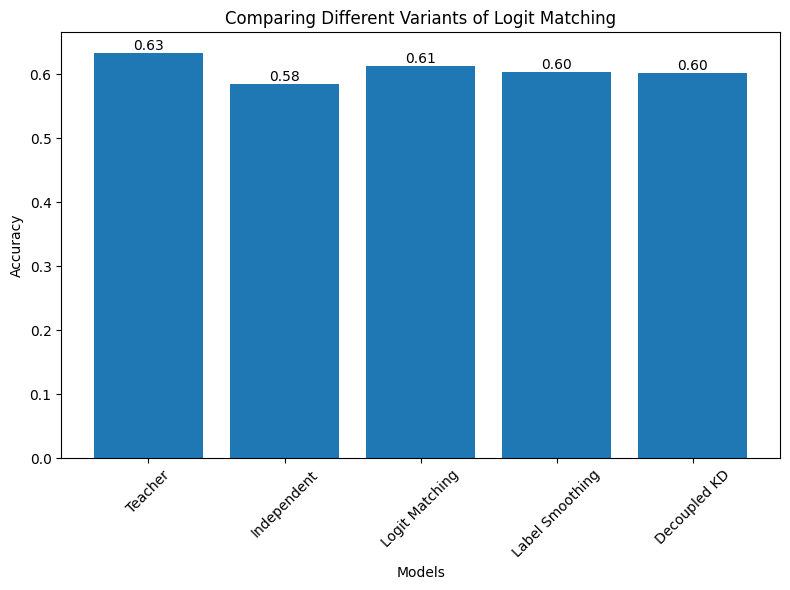

In [ ]:
teacher_acc, indep_acc, lm_acc, lsr_acc, dlm_acc =    0.6336,0.5840,0.6130,0.6028,0.6011
accuracies = [teacher_acc, indep_acc, lm_acc, lsr_acc, dlm_acc]
model_labels = ['Teacher', 'Independent', 'Logit Matching', 'Label Smoothing', 'Decoupled KD']
plot_accuracies(accuracies, model_labels,title='Comparing Different Variants of Logit Matching')

# Task 3.2 (Logit Matching vs Contrastive Representation vs Hints)

In [ ]:
def get_channel_num(model):
    # Get the features part of the model
    features = model.features

    # Iterate through the layers to get output channels
    channel_nums = []
    for layer in features:
        if isinstance(layer, torch.nn.Conv2d):
            channel_nums.append(layer.out_channels)

    # print("channels ", channel_nums)
    return channel_nums[-2]

# get_channel_num(student_model), get_channel_num(teacher_model), get_channel_num(principal_model)
print("Student, Teacher, Principal Model all have same number of channels / dimensions of feature space i.e. 512")

Student, Teacher, Principal Model all have same number of channels / dimensions of feature space i.e. 512


In [ ]:
class FeatureMatching(nn.Module):
	'''
	FitNets: Hints for Thin Deep Nets
	https://arxiv.org/pdf/1412.6550.pdf
	'''
	def __init__(self):
		super(FeatureMatching, self).__init__()

	def forward(self, fm_s, fm_t):
		# generally, a regressor is also applied on student feature map so it has same dimensions as teacher's feature map
		# in our case, they already have same dimensions so need to apply the regressor
		loss = F.mse_loss(fm_s, fm_t)

		return loss




class CRD(nn.Module):
	'''
	Contrastive Representation Distillation
	https://openreview.net/pdf?id=SkgpBJrtvS

	includes two symmetric parts:
	(a) using teacher as anchor, choose positive and negatives over the student side
	(b) using student as anchor, choose positive and negatives over the teacher side

	Args:
		s_dim: the dimension of student's feature
		t_dim: the dimension of teacher's feature
		feat_dim: the dimension of the projection space
		nce_n: number of negatives paired with each positive
		nce_t: the temperature
		nce_mom: the momentum for updating the memory buffer
		n_data: the number of samples in the training set, which is the M in Eq.(19)
	'''
	def __init__(self, s_dim, t_dim, n_data, feat_dim=128, nce_n=4096, nce_t=0.1, nce_mom=0.5):
		super(CRD, self).__init__()
		self.embed_s = Embed(s_dim, feat_dim)
		self.embed_t = Embed(t_dim, feat_dim)
		self.contrast = ContrastMemory(feat_dim, n_data, nce_n, nce_t, nce_mom)
		self.criterion_s = ContrastLoss(n_data)
		self.criterion_t = ContrastLoss(n_data)

	def forward(self, feat_s, feat_t, idx, sample_idx):
		feat_s = self.embed_s(feat_s)
		feat_t = self.embed_t(feat_t)
		out_s, out_t = self.contrast(feat_s, feat_t, idx, sample_idx)
		loss_s = self.criterion_s(out_s)
		loss_t = self.criterion_t(out_t)
		loss = loss_s + loss_t

		return loss


class Embed(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(Embed, self).__init__()
		self.linear = nn.Linear(in_dim, out_dim)

	def forward(self, x):
		x = x.view(x.size(0), -1).to(self.linear.weight.device)
	 	# x = x.view(x.size(0), -1).to(self.linear.weight.device)
		x = self.linear(x)
		x = F.normalize(x, p=2, dim=1)

		return x


class ContrastLoss(nn.Module):
	'''
	contrastive loss, corresponding to Eq.(18)
	'''
	def __init__(self, n_data, eps=1e-7):
		super(ContrastLoss, self).__init__()
		self.n_data = n_data
		self.eps = eps

	def forward(self, x):
		bs = x.size(0)
		N  = x.size(1) - 1
		M  = float(self.n_data)

		# loss for positive pair
		pos_pair = x.select(1, 0)
		log_pos  = torch.div(pos_pair, pos_pair.add(N / M + self.eps)).log_()

		# loss for negative pair
		neg_pair = x.narrow(1, 1, N)
		log_neg  = torch.div(neg_pair.clone().fill_(N / M), neg_pair.add(N / M + self.eps)).log_()

		loss = -(log_pos.sum() + log_neg.sum()) / bs

		return loss


class ContrastMemory(nn.Module):
	def __init__(self, feat_dim, n_data, nce_n, nce_t, nce_mom):
		super(ContrastMemory, self).__init__()
		self.N = nce_n
		self.T = nce_t
		self.momentum = nce_mom
		self.Z_t = None
		self.Z_s = None

		stdv = 1. / math.sqrt(feat_dim / 3.)
		self.register_buffer('memory_t', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))
		self.register_buffer('memory_s', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))

	def forward(self, feat_s, feat_t, idx, sample_idx):
		bs = feat_s.size(0)
		feat_dim = self.memory_s.size(1)
		n_data = self.memory_s.size(0)
		sample_idx = sample_idx.to(self.memory_s.device)

		# using teacher as anchor
		weight_s = torch.index_select(self.memory_s, 0, sample_idx.view(-1)).detach()
		weight_s = weight_s.view(bs, self.N + 1, feat_dim)
		out_t = torch.bmm(weight_s, feat_t.view(bs, feat_dim, 1))
		out_t = torch.exp(torch.div(out_t, self.T)).squeeze().contiguous()

		# using student as anchor
		weight_t = torch.index_select(self.memory_t, 0, sample_idx.view(-1)).detach()
		weight_t = weight_t.view(bs, self.N + 1, feat_dim)
		out_s = torch.bmm(weight_t, feat_s.view(bs, feat_dim, 1))
		out_s = torch.exp(torch.div(out_s, self.T)).squeeze().contiguous()

		# set Z if haven't been set yet
		if self.Z_t is None:
			self.Z_t = (out_t.mean() * n_data).detach().item()
		if self.Z_s is None:
			self.Z_s = (out_s.mean() * n_data).detach().item()

		out_t = torch.div(out_t, self.Z_t)
		out_s = torch.div(out_s, self.Z_s)

		# update memory
		with torch.no_grad():
			idx = idx.to(self.memory_t.device)
			pos_mem_t = torch.index_select(self.memory_t, 0, idx.view(-1))
			pos_mem_t.mul_(self.momentum)
			pos_mem_t.add_(torch.mul(feat_t, 1 - self.momentum))
			pos_mem_t = F.normalize(pos_mem_t, p=2, dim=1)
			self.memory_t.index_copy_(0, idx, pos_mem_t)

			pos_mem_s = torch.index_select(self.memory_s, 0, idx.view(-1))
			pos_mem_s.mul_(self.momentum)
			pos_mem_s.add_(torch.mul(feat_s, 1 - self.momentum))
			pos_mem_s = F.normalize(pos_mem_s, p=2, dim=1)
			self.memory_s.index_copy_(0, idx, pos_mem_s)

		return out_s, out_t

In [ ]:
train_crd_transform = transforms.Compose([
    # transforms.Pad(4, padding_mode='reflect'),
    # transforms.RandomCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
		transforms.Normalize(mean=mean,std=std)
])

train_crd_dataset = CIFAR100IdxSample

train_crd_loader = torch.utils.data.DataLoader(
			train_crd_dataset(
              root  = './datasets',
						  transform = train_crd_transform,
						  train     = True,
						  download  = True,
						  n         = 4096,
						  mode      = 'exact'
      ),
			batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

# test_crd_transform = transforms.Compose([
# 			# transforms.CenterCrop(32),
# 			transforms.ToTensor(),
# 			transforms.Normalize(mean=mean,std=std)
# ])

# test_crd_loader = torch.utils.data.DataLoader(
# 			test_dataset(root      = './datasets',
# 						 transform = test_crd_transform,
# 						 train     = False,
# 						 download  = True),
# 			batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

100%|██████████| 169M/169M [00:13<00:00, 13.0MB/s]


Extracting ./datasets/cifar-100-python.tar.gz to ./datasets


In [ ]:
def train_student_crd(student, features_student, teacher, features_teacher, train_loader, kd, num_epochs=10, alpha=1e-4):
    """Train the model on the training data for CRD """
    print("Distilling the knowledge and training the student on this data for CRD")
    student.train()
    teacher.eval()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=alpha)
    num_batches = len(train_loader)

    for epoch in range(num_epochs):
      running_loss = 0.0
      correct = 0
      total = 0
      for batch_index, (img, target, idx, sample_idx ) in enumerate(train_loader, start=1):
        # print(img.shape, target.shape, idx.shape, sample_idx.shape)
        img = img.to(device)
        target = target.to(device)
        idx = idx.to(device)
        sample_idx = sample_idx.to(device)

        #get features and logits
        feat_s, logit_s = get_features_and_logits(student,features_student,img)
        feat_t, _ = get_features_and_logits(teacher,features_teacher,img,student=False, crd=True)


        feat_s = feat_s.to(device)
        feat_t = feat_t.to(device)
        logit_s = logit_s.to(device)


        #get total loss
        kd_lambda = 1   # 0.2   #for CRD
        kd_loss  = kd(feat_s, feat_t, idx, sample_idx) * kd_lambda
        cls_loss = criterion(logit_s, target)
        total_loss = cls_loss + kd_loss
        # print("total loss",total_loss, "crd + cls", kd_loss , cls_loss)


        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        # # Calculate accuracy
        # _, predicted = torch.max(logit_s, 1)
        # correct += (predicted == labels).sum().item()
        # total += labels.size(0)

        if batch_index % 200 == 0 or batch_index in [1,750]:
            print(f'Batch {batch_index }/{num_batches} - Loss: {total_loss.item():.4f} ')
            # Accuracy: {(correct/total) * 100:.2f}%')

      epoch_loss = running_loss / len(train_loader)
      # epoch_accuracy = correct / total
      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    # return epoch_loss, epoch_accuracy
    return epoch_loss

In [ ]:
#create a new student, train it on featurematching, and evaluate it
student_model, features_student = get_model('student')
criterion_featurematching = FeatureMatching()
train_student(student_model, teacher_model, train_loader, criterion_featurematching, num_epochs=5, alpha=1e-4, features_student=features_student, features_teacher=features_teacher)
fm_acc, fm_probs = evaluate(student_model, test_loader, device)
student_fm = student_model

Distilling the knowledge and training the student on this data FeatureMatching
Batch 1/782 - Loss: 6.7090 Accuracy: 0.00%
Batch 201/782 - Loss: 2.5368 Accuracy: 17.38%
Batch 401/782 - Loss: 2.3418 Accuracy: 25.39%
Batch 601/782 - Loss: 2.0002 Accuracy: 30.62%
Batch 751/782 - Loss: 2.0487 Accuracy: 33.66%
------------------------->Epoch [1/5], Loss: 2.6129 Accuracy : 34.13%
Batch 1/782 - Loss: 1.8645 Accuracy: 51.56%
Batch 201/782 - Loss: 1.3279 Accuracy: 55.39%
Batch 401/782 - Loss: 1.6909 Accuracy: 55.95%
Batch 601/782 - Loss: 1.7728 Accuracy: 56.25%
Batch 751/782 - Loss: 1.3819 Accuracy: 56.70%
------------------------->Epoch [2/5], Loss: 1.5741 Accuracy : 56.77%
Batch 1/782 - Loss: 0.9362 Accuracy: 73.44%
Batch 201/782 - Loss: 0.9775 Accuracy: 70.24%
Batch 401/782 - Loss: 1.0062 Accuracy: 69.66%
Batch 601/782 - Loss: 0.7777 Accuracy: 69.56%
Batch 751/782 - Loss: 1.3326 Accuracy: 69.37%
------------------------->Epoch [3/5], Loss: 1.0619 Accuracy : 69.30%
Batch 1/782 - Loss: 0.7169 A

In [ ]:
student_model, features_student = get_model('student')
criterion_CRD  = CRD(s_dim=get_channel_num(student_model), t_dim=get_channel_num(teacher_model), n_data=len(train_loader.dataset))
train_student_crd(student_model, features_student, teacher_model, features_teacher, train_crd_loader, criterion_CRD, num_epochs=5)
crd_acc, crd_probs = evaluate(student_model, test_loader, device)
student_crd = student_model

Distilling the knowledge and training the student on this data for CRD
Batch 1/782 - Loss: 24.7688 
Batch 200/782 - Loss: 22.0118 
Batch 400/782 - Loss: 21.1322 
Batch 600/782 - Loss: 20.5038 
Batch 750/782 - Loss: 20.1559 
Epoch [1/5], Loss: 21.3283
Batch 1/782 - Loss: 23.3507 
Batch 200/782 - Loss: 20.4650 
Batch 400/782 - Loss: 19.4746 
Batch 600/782 - Loss: 18.8531 
Batch 750/782 - Loss: 19.0457 
Epoch [2/5], Loss: 19.9966
Batch 1/782 - Loss: 15.8277 
Batch 200/782 - Loss: 16.0815 
Batch 400/782 - Loss: 14.8380 
Batch 600/782 - Loss: 15.2340 
Batch 750/782 - Loss: 14.9799 
Epoch [3/5], Loss: 15.5468
Batch 1/782 - Loss: 12.9273 
Batch 200/782 - Loss: 12.6319 
Batch 400/782 - Loss: 12.3039 
Batch 600/782 - Loss: 11.9698 
Batch 750/782 - Loss: 11.5363 
Epoch [4/5], Loss: 12.1721
Batch 1/782 - Loss: 10.2966 
Batch 200/782 - Loss: 10.0848 
Batch 400/782 - Loss: 9.6665 
Batch 600/782 - Loss: 9.9997 
Batch 750/782 - Loss: 9.6441 
Epoch [5/5], Loss: 9.9793
---------------------------EVALUA

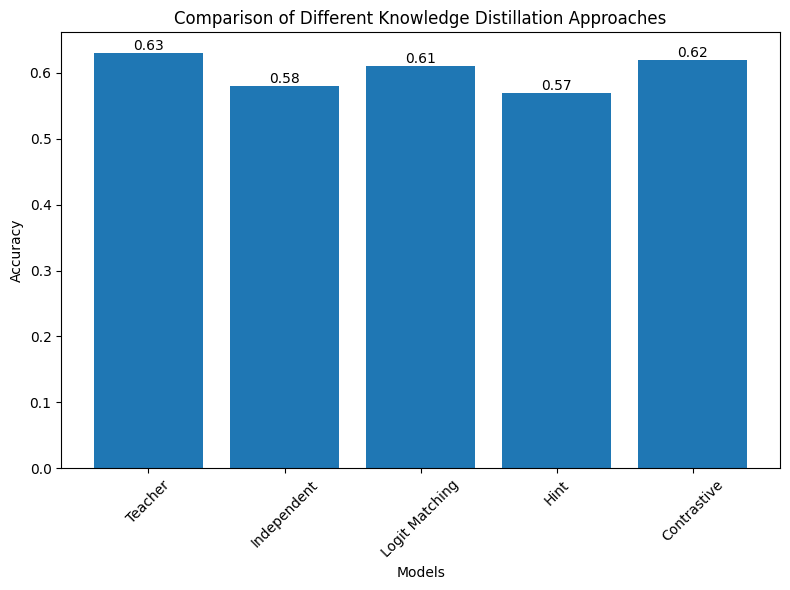

In [ ]:
teacher_acc, indep_acc, lm_acc, fm_acc, crd_acc =    0.63,0.58,0.61,0.57,0.62
accuracies = [teacher_acc, indep_acc, lm_acc, fm_acc, crd_acc]
model_labels = ['Teacher', 'Independent', 'Logit Matching', 'Hint', 'Contrastive']
plot_accuracies(accuracies, model_labels,title='Comparison of Different Knowledge Distillation Approaches')

**Plotting all approaches**

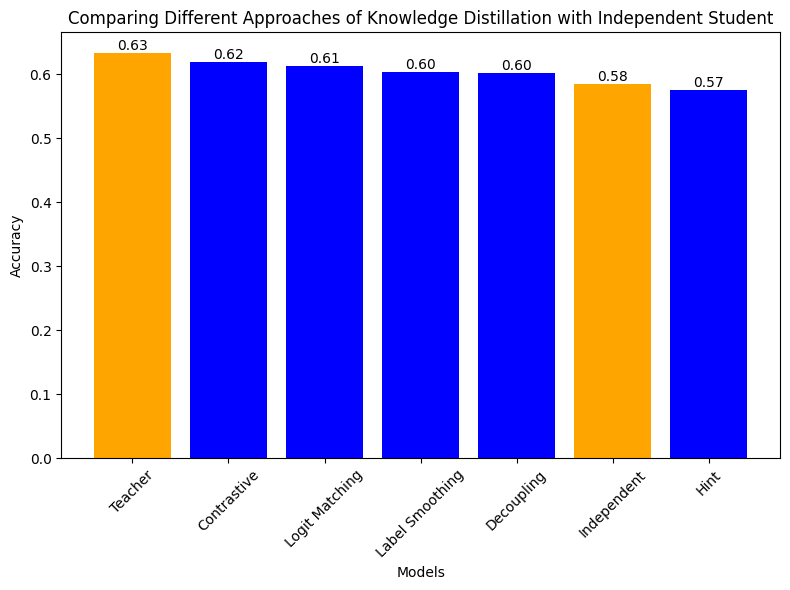

In [ ]:
teacher_acc, indep_acc, lm_acc, lsr_acc, dlm_acc, fm_acc, crd_acc =   0.6336,0.5840,0.6130,0.6028,0.6011,0.5744,0.6185
accuracies = [teacher_acc, crd_acc, lm_acc, lsr_acc, dlm_acc, indep_acc, fm_acc]
model_labels = ['Teacher', 'Contrastive', 'Logit Matching', 'Label Smoothing', 'Decoupling','Independent','Hint']

def plot_accuracies_colored(accuracies, model_labels, title):

    highlight_color, default_color = 'orange','blue'
    highlight_indices = [0,5]

    colors = [highlight_color if i in (highlight_indices or []) else default_color for i in range(len(accuracies))]
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.bar(model_labels, accuracies, color=colors)

    # Adding title and labels
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')

    # Optionally, add accuracy values on top of the bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x labels for better visibility
    plt.tight_layout()
    plt.show()

plot_accuracies_colored(accuracies, model_labels,title='Comparing Different Approaches of Knowledge Distillation with Independent Student')

# Task 3.3 (Comparing Probability Distributions)

100%|██████████| 157/157 [00:07<00:00, 20.70it/s]


torch.Size([10000, 100])
avg disc 1.8017183542251587
avg disc 1.8004523379028223

Test Accuracy: 57.46%

Average Discrepancy (kl_divergence): 1.8005


100%|██████████| 157/157 [00:06<00:00, 24.37it/s]


torch.Size([10000, 100])
avg disc 1.5508298873901367
avg disc 1.5503538520472824

Test Accuracy: 61.85%

Average Discrepancy (kl_divergence): 1.5504


100%|██████████| 157/157 [00:06<00:00, 24.19it/s]


torch.Size([10000, 100])
avg disc 1.7831612825393677
avg disc 1.784157015715435

Test Accuracy: 61.33%

Average Discrepancy (kl_divergence): 1.7842


100%|██████████| 157/157 [00:06<00:00, 24.37it/s]


torch.Size([10000, 100])
avg disc 1.8064879179000854
avg disc 1.8037845177255618

Test Accuracy: 58.43%

Average Discrepancy (kl_divergence): 1.8038


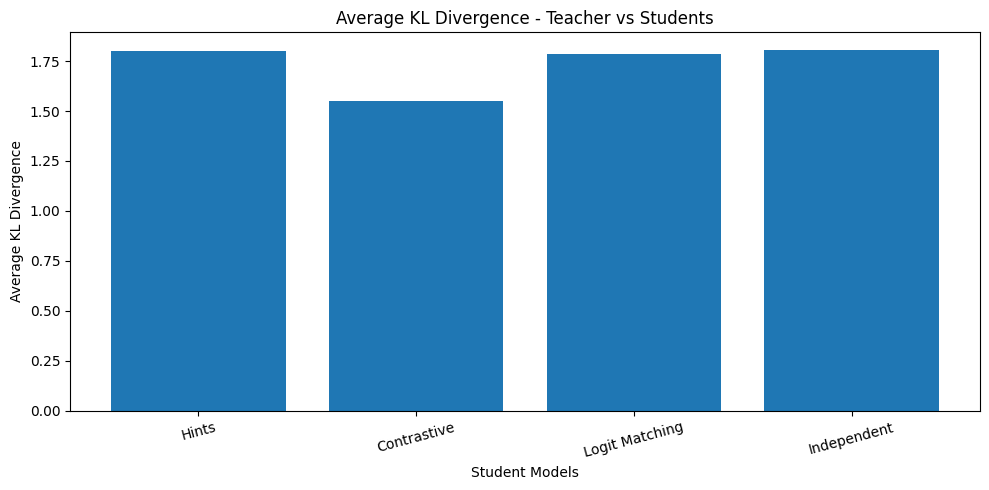

In [ ]:
def evaluate_model_discrepancy(teacher_model, student_model, dataloader, measure='kl_divergence'):
    """
    Evaluates the discrepancy between the teacher and student models' probability distributions.

    Args:
        teacher_model: Trained teacher model (T).
        student_model: Trained student model (SD or SI).
        dataloader: DataLoader for the test data.
        measure: Discrepancy measure to use ('kl_divergence' for KL Divergence, etc.).

    Returns:
        avg_discrepancy: The average discrepancy between the probability distributions of T and S.
        accuracy: The accuracy of the student model on the test set.
    """
    teacher_model.eval()
    student_model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    teacher_model.to(device)
    student_model.to(device)

    all_teacher_probs = []
    all_student_probs = []
    all_preds = []
    all_labels = []

    discs = []
    epsilon = 1e-10  # to ensure non zero prob, otherwise KL div gives inf

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass through teacher and student models
            teacher_outputs = teacher_model(images)
            student_outputs = student_model(images)

            # Convert logits to probabilities (softened labels)
            teacher_probs = F.softmax(teacher_outputs, dim=-1)
            student_probs = F.softmax(student_outputs, dim=-1)

            # Add epsilon to each probability and renormalize (so no 0 probability, hence no inf KL divergence)
            teacher_probs = teacher_probs + epsilon
            teacher_probs = teacher_probs / teacher_probs.sum(dim=-1, keepdim=True)
            student_probs = student_probs + epsilon
            student_probs = student_probs / student_probs.sum(dim=-1, keepdim=True)

            # Store probability distributions
            all_teacher_probs.append(teacher_probs.cpu())
            all_student_probs.append(student_probs.cpu())

            discs.append(F.kl_div(student_probs.log(), teacher_probs, reduction='batchmean').item())

            # Store predictions and labels for accuracy computation
            preds = torch.argmax(student_outputs, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Concatenate all probability tensors
    teacher_probs = torch.cat(all_teacher_probs, dim=0)
    student_probs = torch.cat(all_student_probs, dim=0)
    print(student_probs.shape)

    discrepancy = F.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
    avg_discrepancy = discrepancy.item()
    print("avg disc", avg_discrepancy)

    # avg_discrepancy = sum(discs) / len(discs)  #same as the one above (more or less)
    # print("avg disc", avg_discrepancy)


    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n\033[1mTest Accuracy:\033[0m {accuracy * 100:.2f}%")
    print(f"\n\033[1mAverage Discrepancy ({measure}):\033[0m {avg_discrepancy:.4f}")

    return avg_discrepancy, student_probs, teacher_probs


def visualize_probabilities(avg_kl_divergences, student_labels,title='KL Divergence'):

    # Plotting the average KL divergence
    plt.figure(figsize=(10, 5))
    plt.bar(student_labels, avg_kl_divergences)
    plt.title(f'Average {title} - Teacher vs Students')
    plt.ylabel(f'Average {title}')
    plt.xlabel('Student Models')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


discrepancies = []
probs = []
for stu in [student_fm, student_crd, student_lm, student_indep]:
  avgdisc, p , teacher_probs = evaluate_model_discrepancy(teacher_model, stu, test_loader, measure='kl_divergence')
  discrepancies.append(avgdisc)
  probs.append(p)

probs.append(teacher_probs)


stu_labels = ['Hints', 'Contrastive', 'Logit Matching', 'Independent']
visualize_probabilities(discrepancies, stu_labels)

{'KL Divergence': [2.492663, 2.0313466, 1.9190576, 2.4768748], 'JS Divergence': [0.23809749, 0.21023643, 0.20811899, 0.2359315], 'TVD': [0.4366978, 0.3980542, 0.3829229, 0.43386987], 'Wasserstein Distance': [0.0041200928656571845, 0.003972648767748367, 0.0033751818514482536, 0.0041441816381645865], 'Cosine Similarity': [0.6347626928416197, 0.6766899104556662, 0.6779952547485056, 0.6383623490426549]}
KL Divergence


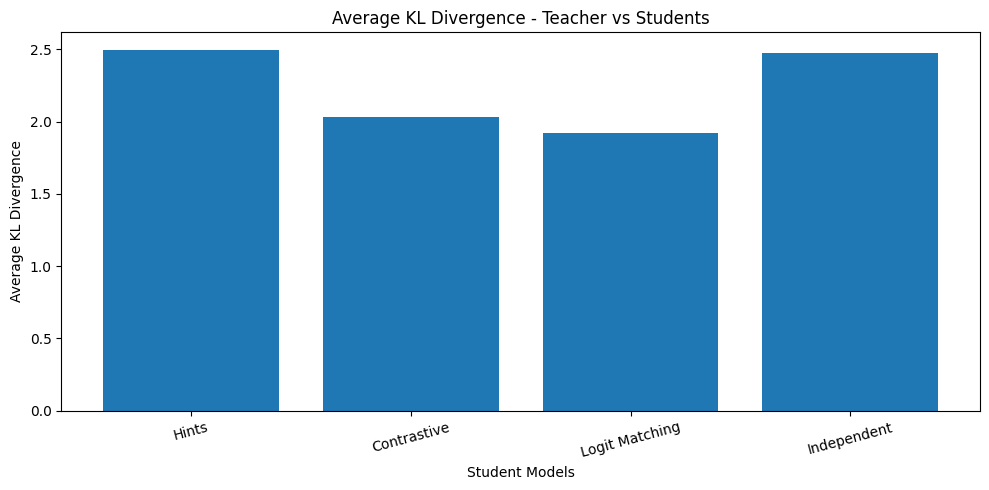

JS Divergence


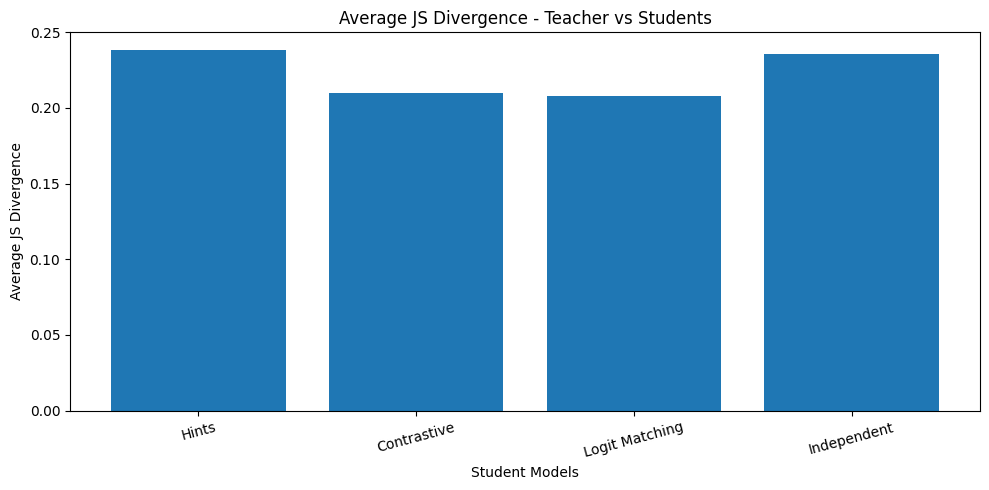

TVD


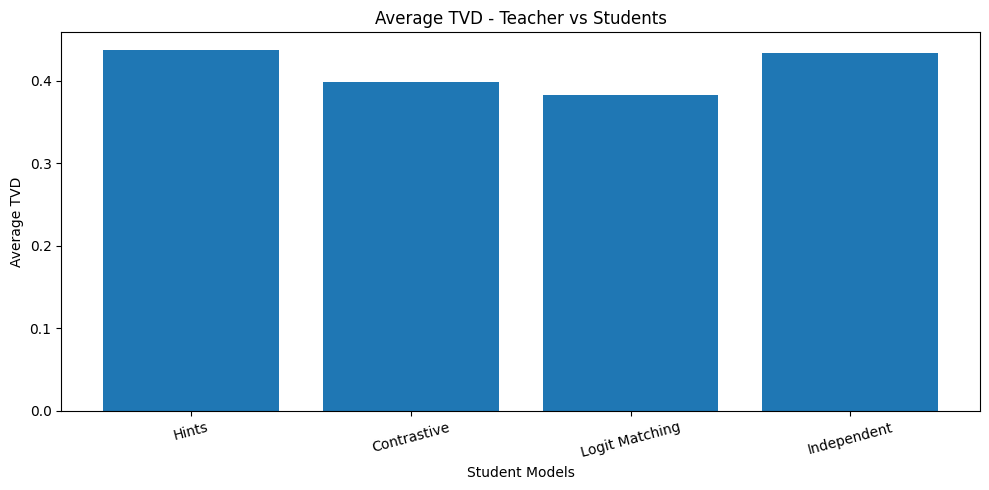

Wasserstein Distance


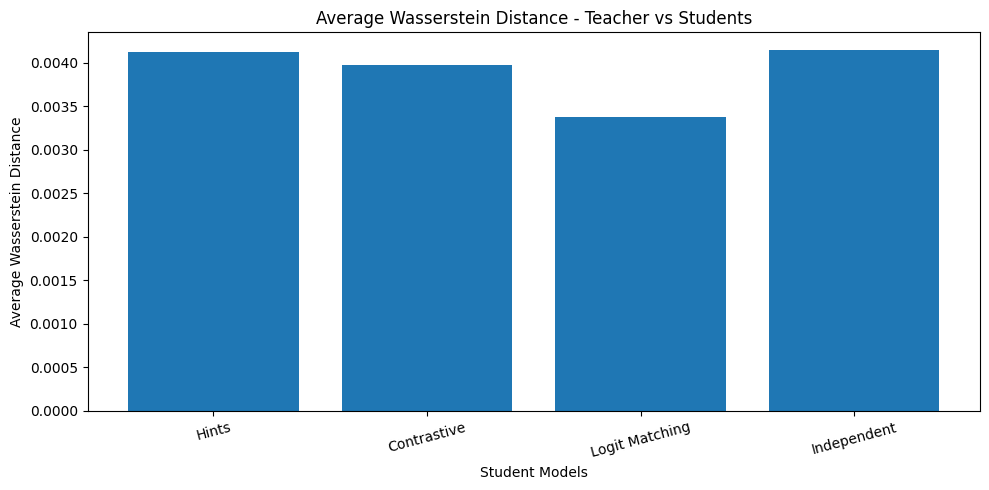

Cosine Similarity


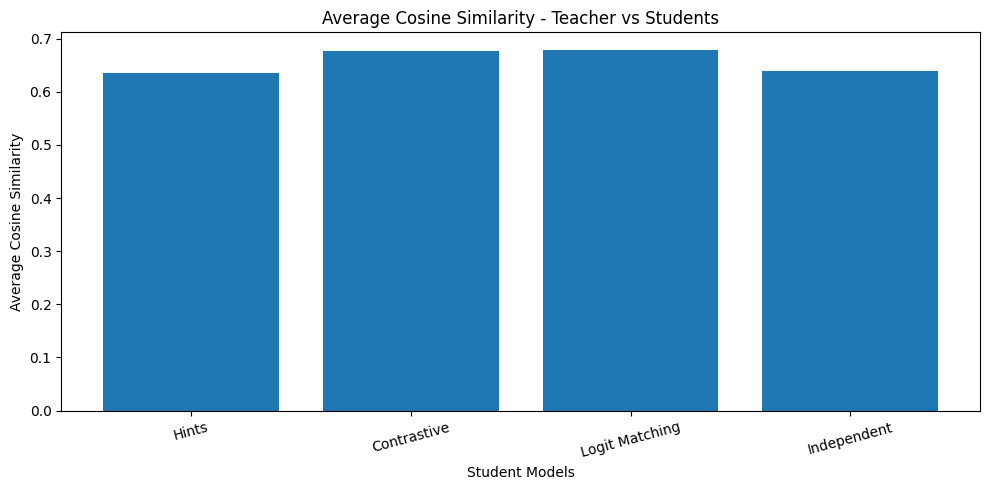

In [ ]:
from scipy.special import rel_entr
from scipy.spatial.distance import cosine
from scipy.stats import wasserstein_distance


def calculate_metrics(student_probs, teacher_probs):
    # Ensure teacher_probs is a tensor
    teacher_probs = teacher_probs.detach().cpu().numpy() if isinstance(teacher_probs, torch.Tensor) else np.array(teacher_probs)

    # Initialize a dictionary to hold lists of metrics for each student
    metrics_dict = {
        "KL Divergence": [],
        "JS Divergence": [],
        "TVD": [],
        "Wasserstein Distance": [],
        "Cosine Similarity": []
    }

    for student in student_probs:
        # Ensure the student_probs tensor is in numpy array format
        student = student.detach().cpu().numpy() if isinstance(student, torch.Tensor) else np.array(student)

        # KL Divergence
        kl_divergence = np.mean(np.sum(rel_entr(student, teacher_probs), axis=1))
        metrics_dict["KL Divergence"].append(kl_divergence)

        # Jensen-Shannon Divergence
        m = 0.5 * (student + teacher_probs)
        js_divergence = 0.5 * np.sum(rel_entr(student, m), axis=1) + 0.5 * np.sum(rel_entr(teacher_probs, m), axis=1)
        js_divergence = np.mean(js_divergence)
        metrics_dict["JS Divergence"].append(js_divergence)

        # Total Variation Distance
        tvd = np.mean(0.5 * np.sum(np.abs(student - teacher_probs), axis=1))
        metrics_dict["TVD"].append(tvd)

        # Wasserstein Distance
        wasserstein = np.mean([wasserstein_distance(student[i], teacher_probs[i]) for i in range(len(student))])
        metrics_dict["Wasserstein Distance"].append(wasserstein)

        # Cosine Similarity
        cosine_sim = np.mean([1 - cosine(student[i], teacher_probs[i]) for i in range(len(student))])
        metrics_dict["Cosine Similarity"].append(cosine_sim)

    return metrics_dict


metrics = calculate_metrics(probs[:-1], probs[-1])
print(metrics)
for metric, values in metrics.items():
    # print(f"{metric}: {np.mean(values):.4f}")
    print(metric)
    visualize_probabilities(values, stu_labels,title=metric)

# Task 3.4 (Examining Transfer of Localized Knowledge from Teacher to Student)


------------------------------------- BATCH INDEX 0 CLASS..... mountain LABEL 49 -----------------------



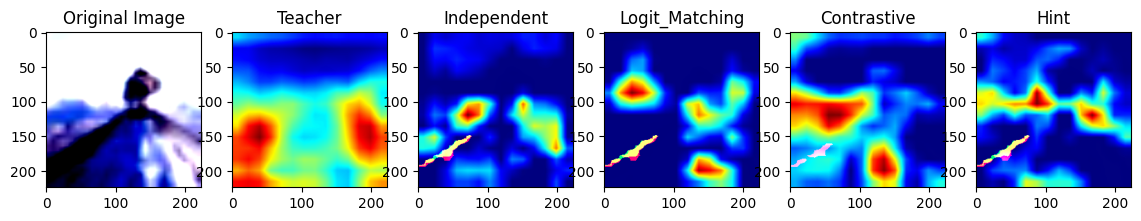


------------------------------------- BATCH INDEX 10 CLASS..... lawn_mower LABEL 41 -----------------------



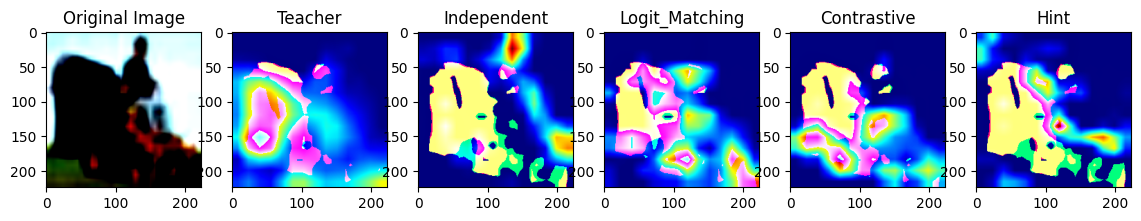


------------------------------------- BATCH INDEX 20 CLASS..... cup LABEL 28 -----------------------



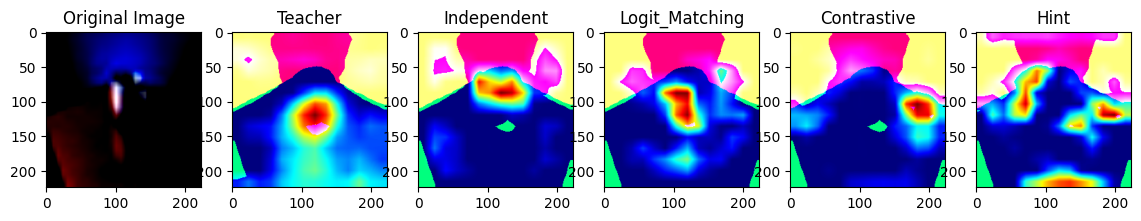


------------------------------------- BATCH INDEX 30 CLASS..... shrew LABEL 74 -----------------------



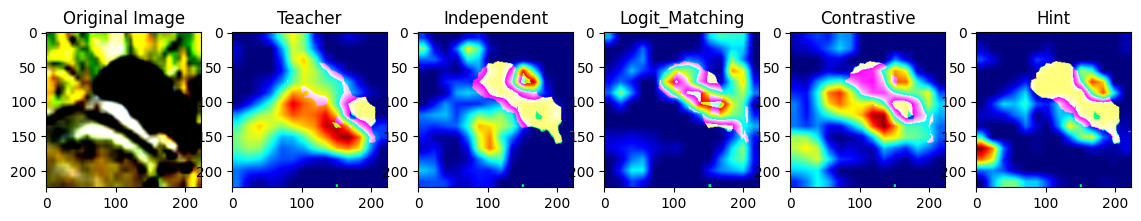


------------------------------------- BATCH INDEX 40 CLASS..... tulip LABEL 92 -----------------------



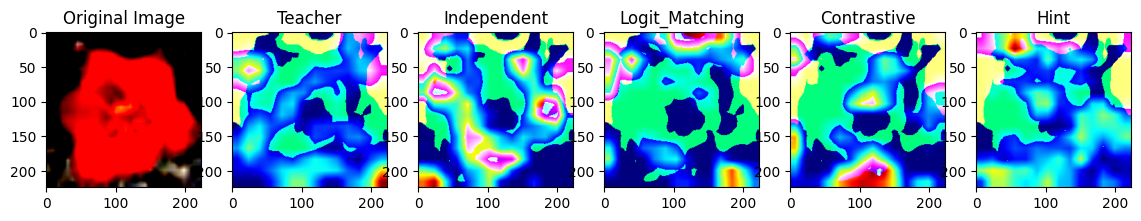


------------------------------------- BATCH INDEX 50 CLASS..... leopard LABEL 42 -----------------------



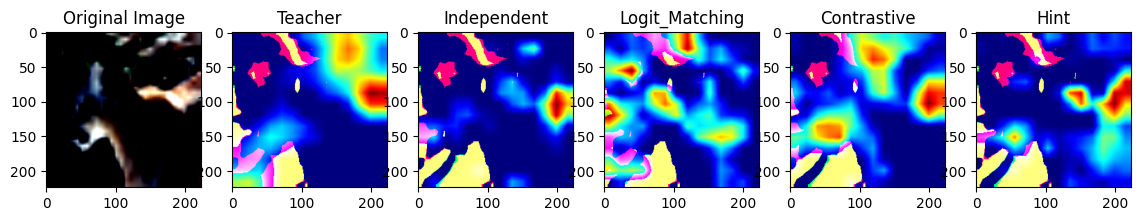


------------------------------------- BATCH INDEX 60 CLASS..... tractor LABEL 89 -----------------------



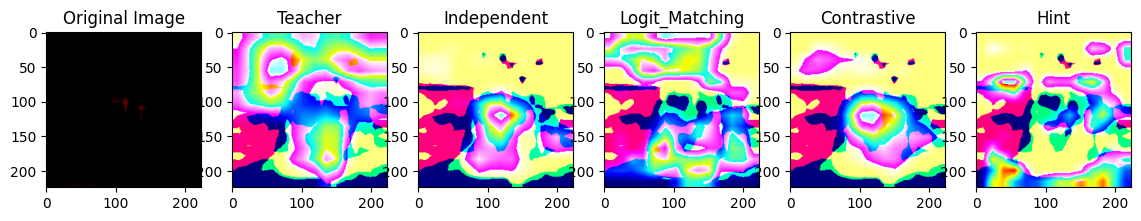


------------------------------------- BATCH INDEX 70 CLASS..... bed LABEL 5 -----------------------



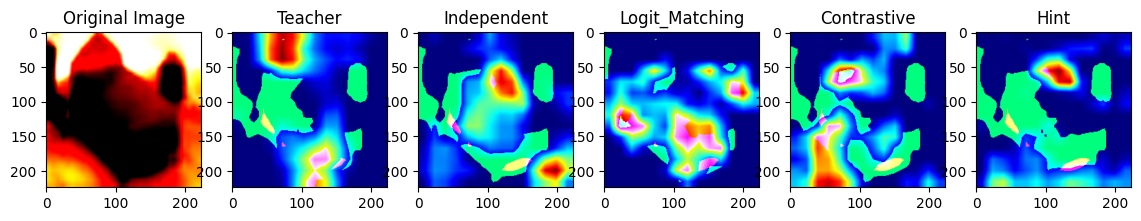


------------------------------------- BATCH INDEX 80 CLASS..... chimpanzee LABEL 21 -----------------------



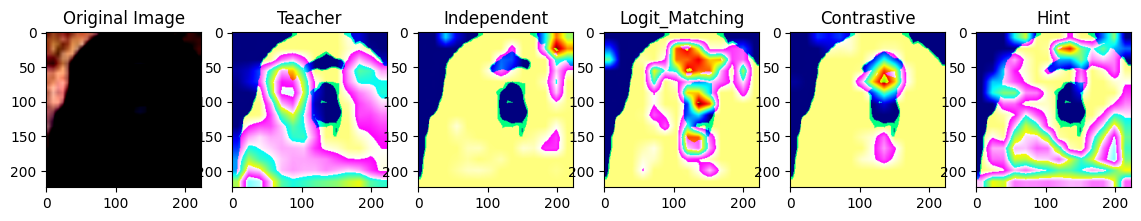


------------------------------------- BATCH INDEX 90 CLASS..... can LABEL 16 -----------------------



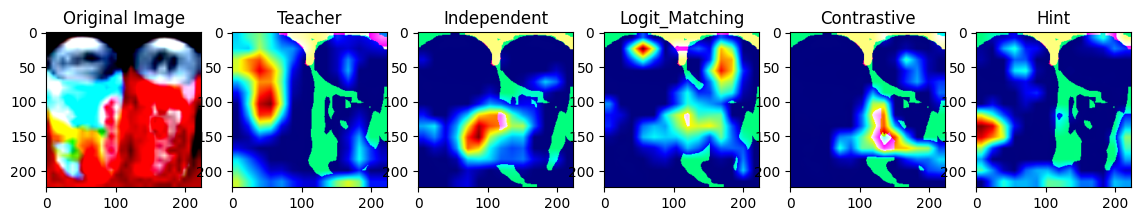


------------------------------------- BATCH INDEX 100 CLASS..... sweet_pepper LABEL 83 -----------------------



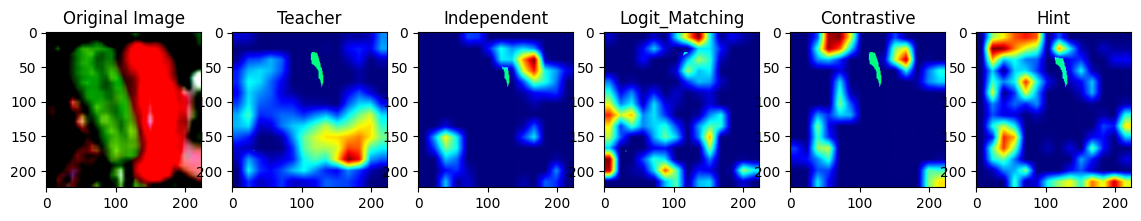


------------------------------------- BATCH INDEX 110 CLASS..... crab LABEL 26 -----------------------



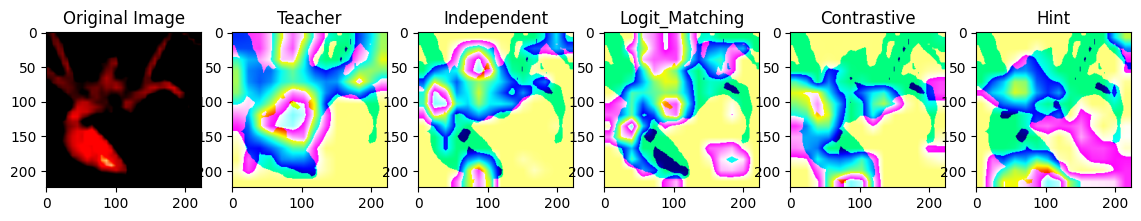


------------------------------------- BATCH INDEX 120 CLASS..... bear LABEL 3 -----------------------



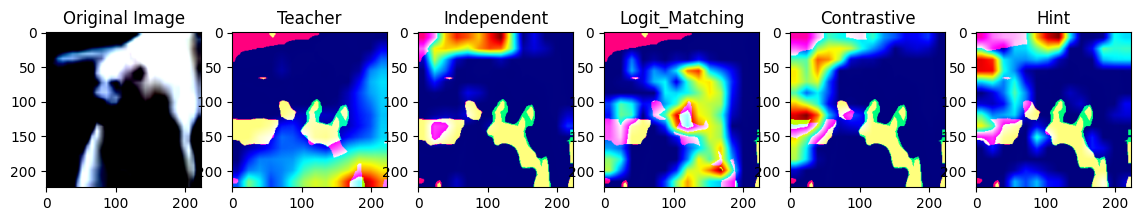


------------------------------------- BATCH INDEX 130 CLASS..... snail LABEL 77 -----------------------



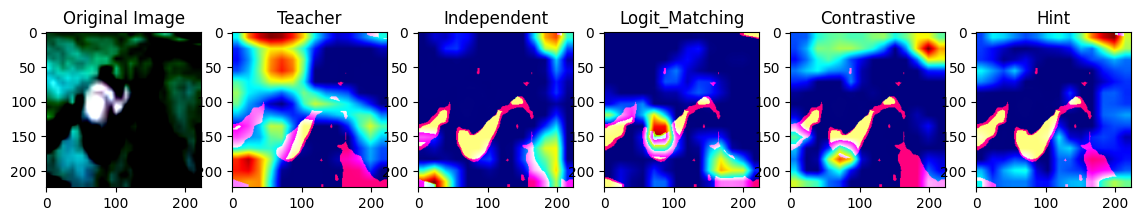


------------------------------------- BATCH INDEX 140 CLASS..... wolf LABEL 97 -----------------------



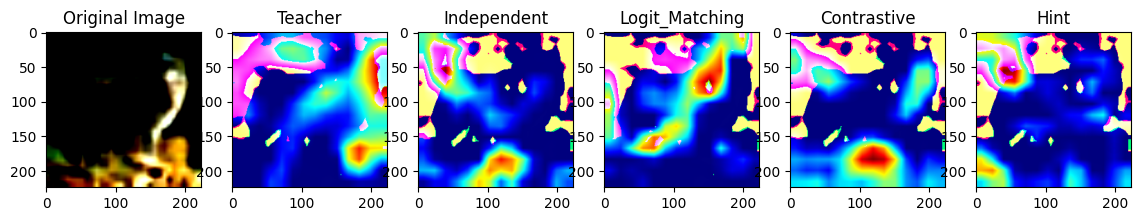


------------------------------------- BATCH INDEX 150 CLASS..... chair LABEL 20 -----------------------



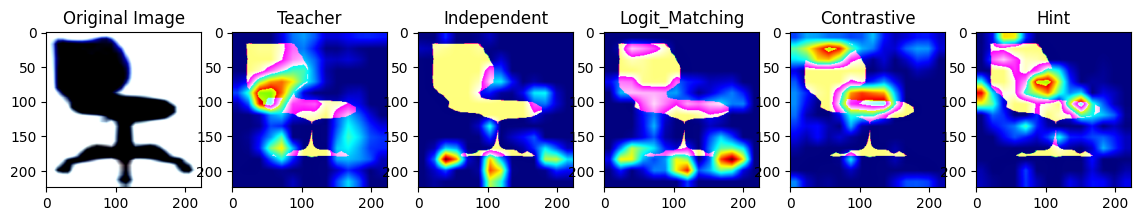

Average Cosine Similarity between Teacher and Independent: 0.40
Average Cosine Similarity between Teacher and Logit_Matching: 0.42
Average Cosine Similarity between Teacher and Contrastive: 0.44
Average Cosine Similarity between Teacher and Hint: 0.44


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# student_model, _ = get_model('student')
# models = [student_model, student_model, student_model, student_model, student_model]
# target_layers = [student_model.features[-1]]


def get_batch_images(images, labels):
    input_tensors = []
    rgb_imgs = []
    rgb_img_unnormalized = []

    for image, label in zip(images, labels):
        resize_transform = transforms.Resize((224, 224))
        input_tensor = resize_transform(image)

        # Convert tensor to image format for visualization
        rgb_img = input_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
        rgb_img_unnormalized_image = rgb_img.astype(np.float32)
        rgb_img_unnormalized_image = np.clip(rgb_img_unnormalized_image, 0, 1)
        rgb_img = rgb_img.astype(np.float32) / 255.0  # Normalize the image
        input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Append the processed data to respective lists
        input_tensors.append(input_tensor)
        rgb_imgs.append(rgb_img)
        rgb_img_unnormalized.append(rgb_img_unnormalized_image)
        # print(input_tensor.shape, rgb_img.shape, rgb_img_unnormalized_image.shape)

        # print('\n-------------------------------------CLASS.....', test_loader.dataset.classes[label], "LABEL", label, '-----------------------\n')

    # Convert lists to tensors
    input_tensors = torch.cat(input_tensors)  # Concatenate along the batch dimension
    return input_tensors, rgb_imgs, rgb_img_unnormalized, len(images)  # Return number of images



# We have to specify the target we want to generate the CAM for...
# targets = [ClassifierOutputTarget(label)]
targets = None
layernum = -2

# Construct the CAM object once, and then re-use it on many images.
models = [teacher_model, student_indep, student_lm, student_crd, student_fm]
target_layerz = [[teacher_model.features[layernum]], [student_indep.features[layernum]], [student_lm.features[layernum]], [student_crd.features[layernum]], [student_fm.features[layernum]]]
model_labels = ['Teacher', 'Independent' , 'Logit_Matching', 'Contrastive', 'Hint']
cosine_scores = {label: [] for label in model_labels[1:]}


for batch_index, (images, labels) in enumerate(test_loader):
    # print("batch index",batch_index)
    input_tensors, _, _, _ = get_batch_images(images, labels)

    if batch_index % 10 == 0:
      print('\n------------------------------------- BATCH INDEX',batch_index,"CLASS.....",test_loader.dataset.classes[labels[0]], "LABEL", labels[0].item(),'-----------------------\n')
      plt.figure(figsize=(14, 16))

    teacher_cam = None  # Store the teacher's CAM for similarity comparison

    for j,model in enumerate(models):

      with GradCAM(model=model, target_layers=target_layerz[j]) as cam:

        grayscale_cams = cam(input_tensor=input_tensors, targets=targets)
        for idx in range(input_tensors.shape[0]):

          rgb_img = input_tensors[idx].permute(1, 2, 0).cpu().numpy()  # Convert tensor to image format
          rgb_img_unnormalized = rgb_img.astype(np.float32)
          rgb_img_unnormalized = np.clip(rgb_img_unnormalized, 0, 1)
          rgb_img = rgb_img.astype(np.float32) / 255.0  # Normalize the image

          grayscale_cam = grayscale_cams[idx]  # CAM for the current image
          visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

          # Convert CAM to tensor for cosine similarity (flatten for cosine_similarity function)
          cam_tensor = torch.tensor(grayscale_cam).flatten()

          if j == 0:  # Teacher model
              teacher_cam = cam_tensor
          else:
              # Calculate cosine similarity with teacher's CAM
              similarity = F.cosine_similarity(cam_tensor.unsqueeze(0), teacher_cam.unsqueeze(0)).item()
              cosine_scores[model_labels[j]].append(similarity)

          if batch_index % 10 == 0 and idx==0:
              plt.subplot(1, 1+len(models), 1)
              plt.imshow(rgb_img_unnormalized)
              plt.title('Original Image')
              plt.subplot(1, 1+len(models), 2+j)
              plt.imshow(visualization)
              plt.title(f'{model_labels[j]}')

    plt.show()



# Calculate average similarity scores across all images for each student
avg_scores = {model: np.mean(scores) for model, scores in cosine_scores.items()}

# Print results
for model, avg_score in avg_scores.items():
    print(f'Average Cosine Similarity between Teacher and {model}: {avg_score:.2f}')

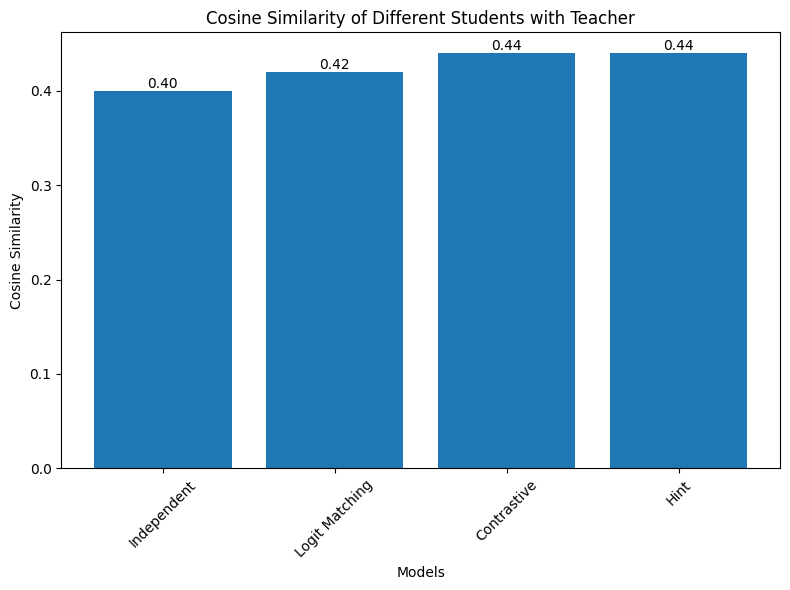

In [ ]:
m_labels = ['Independent' , 'Logit Matching', 'Contrastive', 'Hint']
similarities =   [0.40, 0.42, 0.44, 0.44]  #list(avg_scores.values())


plt.figure(figsize=(8, 6))
plt.bar(m_labels, similarities)

# Adding title and labels
plt.title('Cosine Similarity of Different Students with Teacher')
plt.xlabel('Models')
plt.ylabel('Cosine Similarity')

# Optionally, add accuracy values on top of the bars
for i, acc in enumerate(similarities):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

# Task 3.5 (Examining Transfer of Color Invariance Knowledge from Teacher to Student)

In [ ]:
mean, std = (0.5071, 0.4865, 0.4409),  (0.2673, 0.2564, 0.2762)

# Define the ColorJitter transformation with random parameters
color_jitter = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)


# Compose the transformations (apply color jitter followed by conversion to tensor)
jitter_transform = transforms.Compose([
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

########################### Define color-jittered CIFAR 100 loaders for finetuning teacher + evaluating teacher & student ##########################################

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=jitter_transform)
jitter_train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Load the CIFAR-100 test set with the color jitter transformation applied
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=jitter_transform)
jitter_test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)





#######################################  Define normal CIFAR 100 loader for knowledge distillation of student by CRD  ##########################################

# train_crd_transform = transforms.Compose([
#     # transforms.Pad(4, padding_mode='reflect'),
#     # transforms.RandomCrop(32),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# 		transforms.Normalize(mean=mean,std=std)
# ])


# train_crd_dataset = CIFAR100IdxSample

# train_crd_loader = torch.utils.data.DataLoader(
# 			train_crd_dataset(
#               root  = './datasets',
# 						  transform = train_crd_transform,
# 						  train     = True,
# 						  download  = True,
# 						  n         = 4096,
# 						  mode      = 'exact'
#       ),
# 			batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


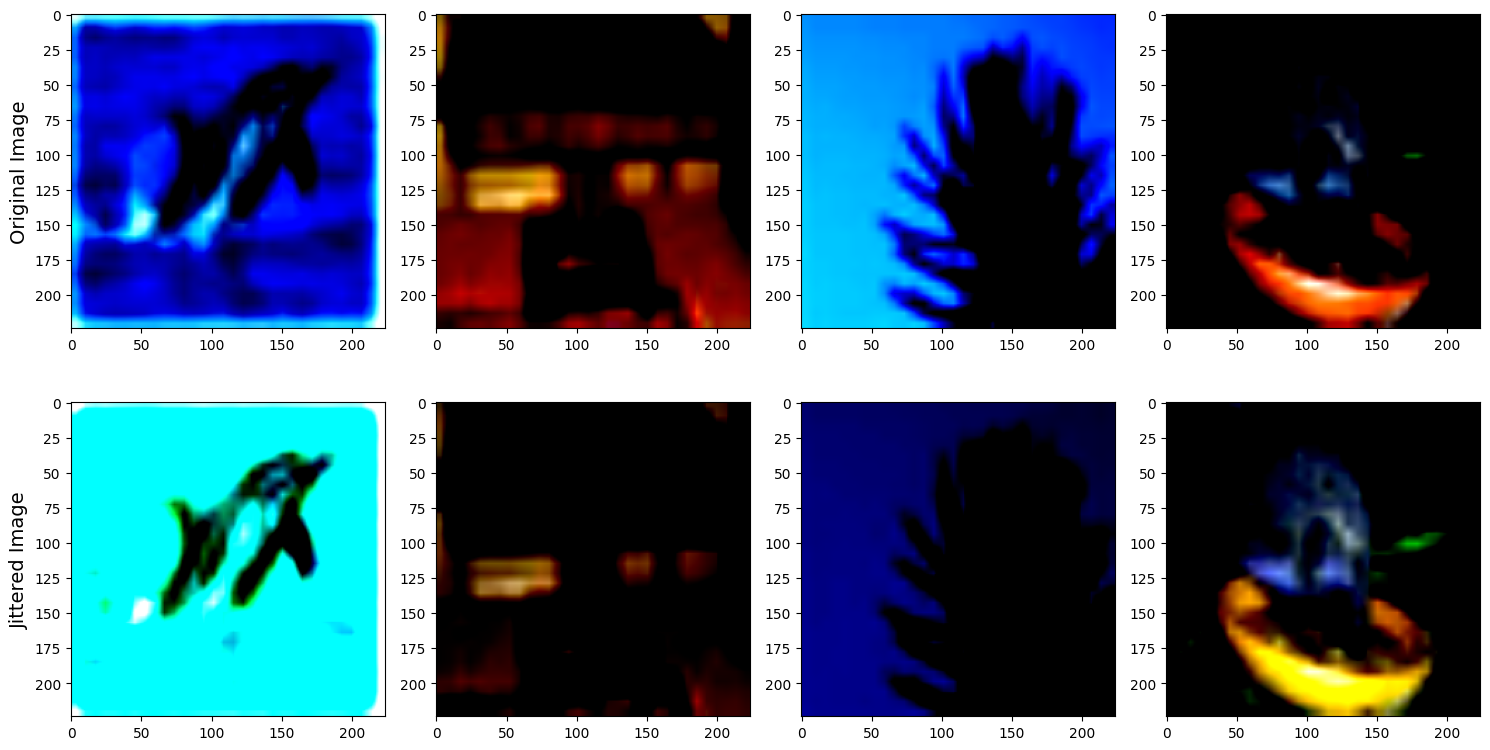

In [ ]:
def display_jitter_comparison(test_loader, jitter_loader,indices):

    # Get images from the specified indices from both loaders
    images_without_jitter = [test_loader.dataset[i][0] for i in indices]
    images_with_jitter = [jitter_loader.dataset[i][0] for i in indices]

    resize_transform = transforms.Resize((224, 224))
    images_without_jitter = [resize_transform(img) for img in images_without_jitter]
    images_with_jitter = [resize_transform(img) for img in images_with_jitter]

    # Convert the list of tensors to a single tensor for easier manipulation
    images_without_jitter = torch.stack(images_without_jitter)
    images_with_jitter = torch.stack(images_with_jitter)

    # Set up the figure to display images in 2 rows (without jitter on top, with jitter on bottom)
    fig, axes = plt.subplots(2, len(indices), figsize=(15, 8))

    # Display the images without jitter on the top row
    for i in range(len(indices)):
        ax = axes[0, i]
        img = images_without_jitter[i].permute(1, 2, 0).numpy()  # Convert to HWC format for display
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        # ax.axis('off')
        if i == 0:
            ax.set_ylabel('Original Image', fontsize=14)

    # Display the images with jitter on the bottom row
    for i in range(len(indices)):
        ax = axes[1, i]
        img = images_with_jitter[i].permute(1, 2, 0).numpy()  # Convert to HWC format for display
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        # ax.axis('off')
        if i == 0:
            ax.set_ylabel('Jittered Image', fontsize=14)

    plt.tight_layout()
    plt.show()



# Compose the transformations (apply color jitter followed by conversion to tensor)
simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the CIFAR-100 test set without the color jitter transformation
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=simple_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


random_indices = random.sample(range(len(test_loader.dataset)), 4)
display_jitter_comparison(test_loader, jitter_test_loader,random_indices)

In [ ]:
#finetune teacher on jitter dataset
jitter_teacher_model, jitter_features_teacher = get_model('teacher')
finetune_teacher(jitter_teacher_model, jitter_train_loader, num_epochs=8, alpha=1e-4)
teacher_jitter_acc, _ = evaluate(jitter_teacher_model, jitter_test_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning the model on this data
Batch 1/782 - Loss: 5.1498 Accuracy: 0.00%
Batch 301/782 - Loss: 2.5925 Accuracy: 19.38%
Batch 601/782 - Loss: 1.9859 Accuracy: 27.71%
Batch 751/782 - Loss: 2.4848 Accuracy: 30.52%
------------------------->Epoch [1/8], Loss: 2.7031 Accuracy : 31.05%
Batch 1/782 - Loss: 2.0172 Accuracy: 46.88%
Batch 301/782 - Loss: 2.0231 Accuracy: 48.81%
Batch 601/782 - Loss: 1.9308 Accuracy: 50.03%
Batch 751/782 - Loss: 1.6196 Accuracy: 50.44%
------------------------->Epoch [2/8], Loss: 1.7911 Accuracy : 50.47%
Batch 1/782 - Loss: 1.3175 Accuracy: 57.81%
Batch 301/782 - Loss: 1.2122 Accuracy: 60.36%
Batch 601/782 - Loss: 1.3317 Accuracy: 60.05%
Batch 751/782 - Loss: 0.9779 Accuracy: 60.22%
------------------------->Epoch [3/8], Loss: 1.4065 Accuracy : 60.22%
Batch 1/782 - Loss: 1.0911 Accuracy: 73.44%
Batch 301/782 - Loss: 1.1206 Accuracy: 66.76%
Batch 601/782 - Loss: 0.7276 Accuracy: 67.36%
Batch 751/782 - Loss: 1.0543 Accuracy: 67.33%
------------------------->Epo

In [ ]:
student_model, features_student = get_model('student')
criterion_CRD  = CRD(s_dim=get_channel_num(student_model), t_dim=get_channel_num(jitter_teacher_model), n_data=len(jitter_train_loader.dataset))
train_student_crd(student_model, features_student, jitter_teacher_model, jitter_features_teacher, train_crd_loader, criterion_CRD, num_epochs=5)
crd_jitter_acc, _ = evaluate(student_model, jitter_test_loader, device)
student_jitter_crd = student_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Distilling the knowledge and training the student on this data for CRD
Batch 1/782 - Loss: 24.4167 
Batch 200/782 - Loss: 21.8664 
Batch 400/782 - Loss: 21.2676 
Batch 600/782 - Loss: 20.0402 
Batch 750/782 - Loss: 19.7231 
Epoch [1/5], Loss: 21.3154
Batch 1/782 - Loss: 22.9045 
Batch 200/782 - Loss: 19.8315 
Batch 400/782 - Loss: 19.2478 
Batch 600/782 - Loss: 19.6005 
Batch 750/782 - Loss: 18.8968 
Epoch [2/5], Loss: 19.7859
Batch 1/782 - Loss: 15.0910 
Batch 200/782 - Loss: 15.3608 
Batch 400/782 - Loss: 15.5006 
Batch 600/782 - Loss: 14.5238 
Batch 750/782 - Loss: 15.6791 
Epoch [3/5], Loss: 15.1131
Batch 1/782 - Loss: 11.7308 
Batch 200/782 - Loss: 11.4079 
Batch 400/782 - Loss: 12.2719 
Batch 600/782 - Loss: 11.1971 
Batch 750/782 - Loss: 10.9055 
Epoch [4/5], Loss: 11.7625
Batch 1/782 - Loss: 9.8274 
Batch 200/782 - Loss: 8.6405 
Batch 400/782 - Loss: 9.2215 
Batch 600/782 - Loss: 9.4153 
Batch 750/782 - Loss: 9.4895 
Epoch [5/5], Loss: 9.6760
---------------------------EVALUATI

In [ ]:
teacher_acc_on_jitter, _ = evaluate(teacher_model, jitter_test_loader, device)
crd_acc_on_jitter , _ = evaluate(student_crd, jitter_test_loader, device)

---------------------------EVALUATING THE MODEL------------------------
Batch 1/157 - Accuracy: 59.38%
Batch 21/157 - Accuracy: 53.20%
Batch 41/157 - Accuracy: 53.54%
Batch 61/157 - Accuracy: 53.36%
Batch 81/157 - Accuracy: 52.76%
Batch 101/157 - Accuracy: 52.48%
Batch 121/157 - Accuracy: 52.84%
Batch 141/157 - Accuracy: 52.85%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 53.31%
---------------------------EVALUATING THE MODEL------------------------
Batch 1/157 - Accuracy: 54.69%
Batch 21/157 - Accuracy: 51.41%
Batch 41/157 - Accuracy: 51.07%
Batch 61/157 - Accuracy: 51.51%
Batch 81/157 - Accuracy: 51.77%
Batch 101/157 - Accuracy: 51.83%
Batch 121/157 - Accuracy: 52.01%
Batch 141/157 - Accuracy: 51.91%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 51.75%


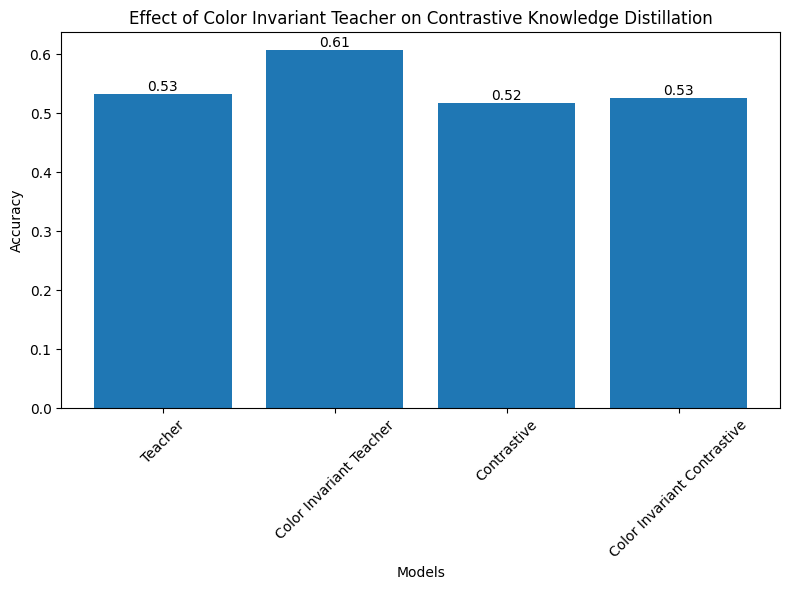

In [ ]:
# teacher_acc, crd_acc, teacher_jitter_acc, crd_jitter_acc = 0.6186, 0.6185, 0.6067, 0.5232
# accuracies = [teacher_acc, teacher_jitter_acc, crd_acc, crd_jitter_acc]
# teacher_jitter_acc, crd_jitter_acc = 0.5917, 0.5232 (OLD)
accuracies = [teacher_acc_on_jitter, teacher_jitter_acc, crd_acc_on_jitter, crd_jitter_acc]
model_labels = ['Teacher', 'Color Invariant Teacher', 'Contrastive', 'Color Invariant Contrastive']
plot_accuracies(accuracies, model_labels, title='Effect of Color Invariant Teacher on Contrastive Knowledge Distillation')

# Task 3.6 (Comparing Results with a Larger Teacher)

In [ ]:
#finetune principal
principal_model, features_principal = get_model('principal')
finetune_teacher(principal_model, train_loader, num_epochs=8, alpha=1e-4)
principal_acc, principal_probs = evaluate(principal_model, test_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 230MB/s]


Finetuning the model on this data
Batch 1/782 - Loss: 4.9358 Accuracy: 0.00%


KeyboardInterrupt: 

In [ ]:
#get a new student each time and train on logit matching
criterion_logitmatching = LogitMatching()
student_model, features_student = get_model('student')
train_student(student_model, principal_model, train_loader, criterion_logitmatching, num_epochs=5, alpha=1e-4)
lm_principal_acc, lm_principal_probs = evaluate(student_model, test_loader, device)

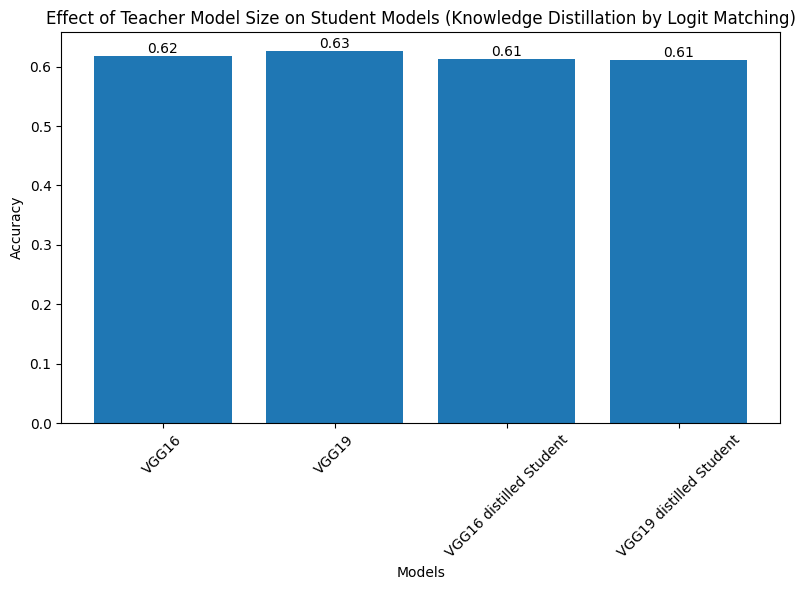

In [ ]:
# teacher_acc, lm_acc, principal_acc, lm_principal_acc = 0.6186, 0.6132, 0.6265, 0.6076

accuracies = [teacher_acc, principal_acc, lm_acc, lm_principal_acc]
model_labels = ['VGG16', 'VGG19', 'VGG16 distilled Student', 'VGG19 distilled Student']
plot_accuracies(accuracies, model_labels, title='Effect of Teacher Model Size on Student Models (Knowledge Distillation by Logit Matching)')